In [1]:
import io
import re
import json
import string
import codecs
import itertools
import sys
import pandas as pd
import operator
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# import numpy as np

from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize

In [48]:
df_sales_templates = pd.read_csv('C:/Users/Aimee/Downloads/Templates_sales_email.csv',usecols=["email","label"],encoding = "ISO-8859-1",error_bad_lines=False)
# df_nonsales = pd.read_csv('C:/Users/Aimee/non_sales_emails.csv',usecols=["email","label"])

In [49]:
df_sales_templates.groupby("label").count()

,email
label,
Break Up,11
Cold Email Templates,33
Follow Up Email Templates,31
Inbound,19
LinkedIn Outreach InMail Templates,8
Other Sales Email,18
Referral Outreach Email Templates,4
Researched Outreach Email Templates,33
Sequence,16


In [50]:
# df2 =df_nonsales[1000:1050]
df_result = pd.concat([df_sales_templates], axis=0,sort=False)
df_result['index'] = range(0, len(df_result))
df_result = df_result.drop_duplicates("email")
df_result['labels'] = df_result['label'].factorize()[0]
df_result = df_result[df_result.labels!= -1]

In [51]:
from nltk.corpus import stopwords
import string 
ascii_str = string.printable
digits_str = string.digits
punctuation_str = string.punctuation
stop_words = stopwords.words('english')

In [52]:
def token(texts):
    if type(texts) is str:
        texts = texts.lower()
        token_text = " ".join([w for w in texts.split()])
        return token_text
df_result['email_token'] = df_result['email'].apply(lambda x: token(x)).astype('str') 

In [53]:
def remove_pun(texts):
    texts = texts.lower()
    remove_pun = "".join([word for word in texts if word not in punctuation_str])
#         clean_data = "".join([word for word in remove_pun if word in list(ascii_str)])
    return remove_pun
    
# df_result['email_nopun1'] = df_result['email_nopun'].apply(lambda x: remove_pun(x))
df_result['email_nopun'] = df_result['email_token'].apply(lambda x: remove_pun(x))

In [54]:
def remove_ascii(texts):
    clean_data = "".join([word for word in texts if word in list(ascii_str)])
    return clean_data

df_result['no_ascii'] = df_result['email_nopun'].apply(lambda x: remove_ascii(x))

In [55]:
def remove_stop(texts):
    word_tokens = word_tokenize(texts.lower()) 
    clean_data = " ".join([word for word in word_tokens if word not in stop_words])
    return clean_data
df_result['no_stopwords'] = df_result['no_ascii'].apply(lambda x: remove_stop(x))

In [56]:
import re
def no_digit(texts):
    word_tokens = word_tokenize(texts) 
    output=[]
    for i in word_tokens:
        output.append(re.sub(r'\d+', '',i))
    no_digit = " ".join([word for word in word_tokens if word in output])
    return no_digit
df_result['no_digits'] = df_result['no_stopwords'].apply(lambda x: no_digit(x))

In [57]:
noise_list = ['hello','hi','name','sorry','im','would',"html"]

def remove(texts):
    w = word_tokenize(texts.lower())
    remove_pun = " ".join([word for word in w if word not in noise_list])
    return remove_pun

df_result['emails'] = df_result['no_digits'].apply(lambda x: remove(x))

In [58]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
def lemma(texts):
    w = word_tokenize(texts.lower())
    lemmatizer=WordNetLemmatizer()
    lemma_w = ",".join(lemmatizer.lemmatize(word,pos="v") for word in w)
    
    return lemma_w
df_result['email1'] = df_result['emails'].apply(lambda x: lemma(x))

In [59]:
df_result=df_result.drop(['email', 'email_token','email_nopun','no_ascii','no_stopwords','no_digits','emails'], axis=1)
df_result.head()

,label,index,labels,email1
0,Cold Email Templates,0,0,"aimee,companywe,help,specific,company,type,one..."
1,Cold Email Templates,1,0,"mike,nick,cofounder,smart,host,help,property,m..."
2,Cold Email Templates,2,0,"id,like,discuss,lead,gen,efforts,help,industry..."
3,Cold Email Templates,3,0,"myname,mycompany,company,make,sales,consistent..."
4,Cold Email Templates,4,0,"try,figure,charge,lead,general,statement,compa..."


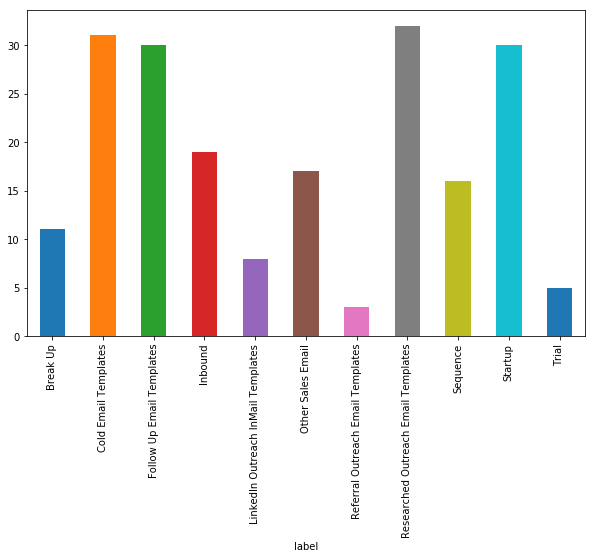

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
df_result.groupby('label').email1.count().plot.bar(ylim=0)
plt.show()

In [61]:
def process_message(df):
    clean_data_set=[]
    train_data = df_result.email1
    data_arr=[]
    for e_arr in train_data:
        data_arr.append([e_arr])
    return data_arr
clean_data_set = process_message(df_result)

In [62]:
str_=[]
for c in clean_data_set:
    str_.append(" ".join(c))
df = pd.DataFrame({'email':str_,"label":df_result.label,"index":df_result.index,"labels":df_result.labels})

In [63]:
X_train, X_test, y_train, y_test = train_test_split( df.email, df.label,test_size=0.15,random_state=0)

In [64]:
tfidf = TfidfVectorizer(max_features=None, use_idf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = df.labels
features = tfidf.fit_transform(df.email).toarray()
tfidf_feature_names = tfidf.get_feature_names()
features.shape

(202, 360)

In [65]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [66]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    SVC(kernel="linear", degree=2),
    MultinomialNB(),
    LogisticRegression(tol=0.001, C=1.0,intercept_scaling=0.2, random_state=0, max_iter=100, n_jobs=1),
    SGDClassifier(loss="modified_huber",penalty='l2', random_state=5, max_iter=12),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Aimee\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Aimee\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Aimee\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Aimee\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The mi

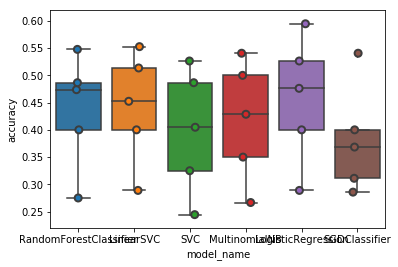

In [67]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=7, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [68]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.441483
LogisticRegression        0.457198
MultinomialNB             0.417156
RandomForestClassifier    0.436558
SGDClassifier             0.381157
SVC                       0.397402
Name: accuracy, dtype: float64

In [347]:
from sklearn.model_selection import train_test_split
# model = LinearSVC()
# model = SVC(kernel="linear", degree=2)
# model = LogisticRegression(penalty="l2", tol=0.0001, C=1.0,intercept_scaling=0.5,random_state=0, max_iter=15, n_jobs=1)
model = SGDClassifier(loss="modified_huber",penalty='l1', max_iter=7,random_state=15,alpha=0.0001, tol=None, n_jobs=-1)
# model = SGDClassifier(loss='hinge', penalty='l2',alpha=0.001, random_state=12, max_iter=5, tol=None, n_jobs=-1)
# model=MultinomialNB()
X_train2, X_test2, y_train2, y_test2= train_test_split(features, labels, test_size=0.2, random_state=0)

In [348]:
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_test2)

In [349]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test2, y_pred2, 
                                    target_names=df.label.unique()))

                                     precision    recall  f1-score   support

               Cold Email Templates       1.00      0.60      0.75        10
Researched Outreach Email Templates       0.60      0.75      0.67         4
  Referral Outreach Email Templates       0.00      0.00      0.00         0
 LinkedIn Outreach InMail Templates       0.50      1.00      0.67         1
          Follow Up Email Templates       0.57      0.67      0.62         6
                           Break Up       0.00      0.00      0.00         1
                              Trial       1.00      1.00      1.00         1
                            Startup       1.00      0.40      0.57         5
                  Other Sales Email       0.00      0.00      0.00         4
                            Inbound       1.00      1.00      1.00         3
                           Sequence       0.00      0.00      0.00         6

                        avg / total       0.62      0.49      0.52        

C:\Users\Aimee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Aimee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


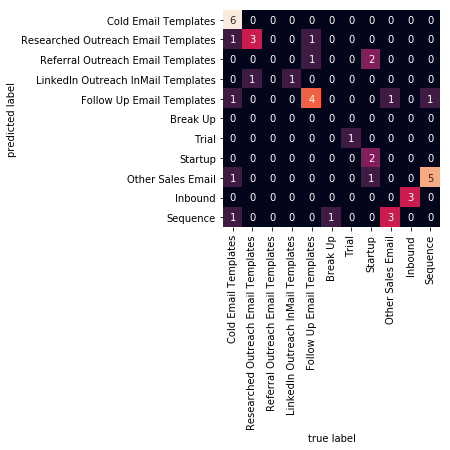

In [350]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test2, y_pred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=df.label.unique(), yticklabels=df.label.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [351]:
predic_file = pd.read_csv('C:/Users/Aimee/email_new_data2.csv',usecols=["email"])
predic_file.head()

,email
0,testHello Paul Hennessy Write your email co...
1,"test,Hello Marina Aranda Write your email c..."
2,"Free leads in exchange for feedback!""Hello Th..."
3,"Free leads in exchange for feedback!""Hello De..."
4,"Free leads in exchange for feedback!""Hello De..."


In [352]:
def process_message1(df):
    clean_data_set=[]
    train_data = predic_file.email
    data_arr=[]
    for e_arr in train_data:
        data_arr.append([e_arr])
    return data_arr
clean_data_set = process_message(df_result)

In [353]:
pred_data_set=process_message1(predic_file["email"])
# pred_data_set

In [354]:
str_pred=[]
for c in pred_data_set:
    str_pred.append(" ".join(c))

In [355]:
result_dict=df_result.set_index('labels')["label"].to_dict()
# result_dict

In [356]:
text_features = tfidf.transform(str_pred)
predictions = model.predict(text_features)
dic_pred_file={}
for text, predicted in zip(pred_data_set, predictions):
#     print('"{}"'.format(text))
#     print("  - Predicted as: '{}'".format(result_dict[predicted]))
#     print("")
    dic_pred_file[" ".join(text)]=result_dict[predicted]
dic_pred_file
# try:
#     with open('predicton_result.csv', 'w',encoding='utf-8') as f:
#         for key in dic_pred_file.keys():
#             f.write("%s,%s\n"%(key,dic_pred_file[key]))
# except IOError:
#     print("I/O error") 

{'testHello  Paul   Hennessy Write your email content here, use the controls above or simply paste in your content...\xa0\r\n--\xa0\r\n': 'Follow Up Email Templates',
 'test,Hello  Marina   Aranda Write your email content here use the controls above or simply paste in your content...\xa0': 'Follow Up Email Templates',
 'Free leads in exchange for feedback!"Hello  Thu \xa0\r\nHope you don\'t mind me contacting you.\r\nWe are offically launching our new\xa0Lead Generation\xa0application next month which gives access to a huge leads database with instant email communication and analytics.\r\nWith this in mind we are inviting selected professionals to gain a\xa0free month (400 leads)\xa0of use in exchange for valuable feedback.\r\nPlease click on this link\xa0Generate Leads Now!\xa0to sign up with\xa0the invitation code \xa0UXWV-4TPZ-VHY7-XWU6': 'Referral Outreach Email Templates',
 'Free leads in exchange for feedback!"Hello  Dejan \xa0\r\nHope you don\'t mind me contacting you.\r\nWe are